# Run 35 dIdV 2

Author: Maggie Reed

Last Updated: 11/30/2023

Description
-----

This notebook contains the processing analysis, and template generation for the longer continuous data set taken near the end of run 35. dIdV was taken during this data set intermittently. 

I utilized an IV sweep also taken near the continuous data set to generate a template for each device, aka a template made via the "true current" method, wherein we get the current offsets from the IV sweep, and refit the didv with them. This template is a good "first go." And will most likely need to be remade to highlight various features (singles, delta chi2....). 

The templates generated for the small and big IrPt device will need to be reworked and improved. This fit to the response of the devices is not great. 

# Setup

In [2]:
#imports 
import qetpy as qp
import numpy as np
import pandas as pd
from pprint import pprint
import pytesdaq.io as h5io
import pickle
import random as rand
from glob import glob

#plotting stuff 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.figsize'] = [10, 6.5]

#processing notebook progress bar
from tqdm.notebook import tqdm

h5 = h5io.H5Reader()


In [4]:
# channels to be analyzed
channels = ['CPDv21Al2O3']

channels_rp = [0.00365,0.00265,0.00255] #values can be found in the run35 drive performance doc

# data path 
data_path = '/sdata2/runs/run35/raw/continuous_I2_D20231122_T215934' #long continuous set 
didv_bor_series = 'I2_D20231122_T215959'
#didv_bor_I2_D20231122_T215959_F0001.hdf5
basedir = '/home/maggie_reed/analysis/run35/didv/figs/'
file_list = glob(f'{data_path}/*{didv_bor_series}_*.hdf5')
fs = 1.25e6

# Checking autocut efficiencies

In [5]:
for ichan,chan in enumerate(channels):
    # display
    print(f'Channel {chan} checking dIdV cut efficiencies')
    
    # get traces
    traces, info = h5.read_many_events(
        filepath=file_list,
        detector_chans=chan,
        nevents=3000,
        output_format=2, 
        include_metadata=True,
        adctoamp=True)
    traces = traces[:,0,:]
    sample_rate = info[0]['sample_rate']
    # cut pileup
    cuts, diags = qp.autocuts_didv(traces, fs=sample_rate, lgc_diagnostics=True, verbose=True)
    precutbase = len(diags['df']['baseline'])
    postcutbase = len(diags['df']['baseline'][diags['df']['baseline_cut']])
    print('precutbaseline: ', precutbase)
    print('postuctbaseline: ', postcutbase)
    print('baseline cut eff: ', postcutbase/precutbase)
    
    precutofamp = len(diags['df']['ofamps'])
    postcutofamp = len(diags['df']['ofamps'][diags['df']['ofamps_cut']])
    print('precutofamp: ', precutofamp)
    print('postuctofamp: ', postcutofamp)
    print('ofamp cut eff: ', postcutofamp/precutofamp)
    
    precutchi2 = len(diags['df']['ofchi2'])
    postcutchi2 = len(diags['df']['ofchi2'][diags['df']['ofchi2_cut']])
    print('precutchi2: ', precutchi2)
    print('postuctchi2: ', postcutchi2)
    print('chi2 cut eff: ', postcutchi2/precutchi2) 
    toteff = sum(cuts==True)/len(traces)
    print('total eff:', toteff)

Channel CPDv21Al2O3 checking dIdV cut efficiencies
precutbaseline:  1215
postuctbaseline:  791
baseline cut eff:  0.6510288065843621
precutofamp:  1215
postuctofamp:  187
ofamp cut eff:  0.15390946502057612
precutchi2:  1215
postuctchi2:  169
chi2 cut eff:  0.1390946502057613
total eff: 0.1390946502057613


# dIdV initial processing

In [42]:
file_list = glob(f'{data_path}/*{didv_bor_series}_*.hdf5')

detector_settings = h5.get_detector_config(file_name=file_list[0])

for ichan,chan in enumerate(channels):
    # display
    print(f'Channel {chan} dIdV processing')
    
    # get traces
    traces, info = h5.read_many_events(
        filepath=file_list,
        detector_chans=chan,
        nevents=3000,
        output_format=2, 
        include_metadata=True,
        adctoamp=True)
    traces = traces[:,0,:]
    sample_rate = info[0]['sample_rate']
    # cut pileup
    cut = qp.autocuts_didv(traces, fs=sample_rate, lgc_diagnostics=False, lgc_plot=False, verbose=True)

    if ichan==1:
        
        rp_small = channels_rp[ichan]
        rshunt_small = float(detector_settings[chan]['shunt_resistance'])
        sg_freq_small = float(detector_settings[chan]['signal_gen_frequency'])
        sg_current_small = float(detector_settings[chan]['signal_gen_current'])
        tes_bias_small = float(detector_settings[chan]['tes_bias'])
        voltage_bias_small = tes_bias_small*rshunt_small
        # Fit data
        didvobj_small = qp.DIDV(traces[cut], 
                          sample_rate, 
                          sg_freq_small, 
                          sg_current_small, 
                          rshunt_small, 
                          rp=rp_small, 
                          dt0=3e-6, 
                          dutycycle=0.5, 
                          add180phase=False)
        # process
        didvobj_small.processtraces()
        # 2 pole fit
        didvobj_small.dofit(2)
        didvobj_small.dofit(3)
        # 3-pole fit resutls
        result_small = didvobj_small.fitresult(3)
        ###  calc power (infinite loop gain)   
        # TES resistance 
        r_tes_small = abs(1/result_small['didv0']) + rp_small + rshunt_small  
        # current in TES 
        i_tes_small = voltage_bias_small/(r_tes_small + rp_small + rshunt_small)   
        # Power = V x I   (- load power rload*i_tes^2  (in pico Watt)
        power_tes_small = 1e12 *(voltage_bias_small*i_tes_small - (rp_small+rshunt_small)*pow(i_tes_small,2))
        print(chan + ' bias power @ ' + str(round(r_tes_small*1e3, 2))+ ' mOhms = ' 
              + str(round(power_tes_small*1e3,2)) + ' fWatts')
        
        
    if ichan==2:
        rp_big = channels_rp[ichan]
        rshunt_big = float(detector_settings[chan]['shunt_resistance'])
        sg_freq_big = float(detector_settings[chan]['signal_gen_frequency'])
        sg_current_big = float(detector_settings[chan]['signal_gen_current'])
        tes_bias_big = float(detector_settings[chan]['tes_bias'])
        voltage_bias_big = tes_bias_big*rshunt_big
        # Fit data
        didvobj_big = qp.DIDV(traces[cut], 
                          sample_rate, 
                          sg_freq_big, 
                          sg_current_big, 
                          rshunt_big, 
                          rp=rp_big, 
                          dt0=3e-6, 
                          dutycycle=0.5, 
                          add180phase=False)
        # process
        didvobj_big.processtraces()
        # 2 pole fit
        didvobj_big.dofit(2)
        didvobj_big.dofit(3)
        # 3-pole fit resutls
        result_big = didvobj_big.fitresult(3)
        ###  calc power (infinite loop gain)   
        # TES resistance 
        r_tes_big = abs(1/result_big['didv0']) + rp_big + rshunt_big   
        # current in TES 
        i_tes_big = voltage_bias_big/(r_tes_big + rp_big + rshunt_big)   
        # Power = V x I   (- load power rload*i_tes^2  (in pico Watt)
        power_tes_big = 1e12 *(voltage_bias_big*i_tes_big - (rp_big+rshunt_big)*pow(i_tes_big,2))
        print(chan + ' bias power @ ' + str(round(r_tes_big*1e3, 2))+ ' mOhms = ' 
              + str(round(power_tes_big*1e3,2)) + ' fWatts')
        
    if ichan==0:
        rp_sap = channels_rp[ichan]
        rshunt_sap = float(detector_settings[chan]['shunt_resistance'])
        sg_freq_sap = float(detector_settings[chan]['signal_gen_frequency'])
        sg_current_sap = float(detector_settings[chan]['signal_gen_current'])
        tes_bias_sap= float(detector_settings[chan]['tes_bias'])
        voltage_bias_sap = tes_bias_sap*rshunt_sap
        # Fit data
        didvobj_sap = qp.DIDV(traces[cut], 
                          sample_rate, 
                          sg_freq_sap, 
                          sg_current_sap, 
                          rshunt_sap, 
                          rp=rp_sap, 
                          dt0=3e-6, 
                          dutycycle=0.5, 
                          add180phase=False)
         # process
        didvobj_sap.processtraces()
        # 2 pole fit
        didvobj_sap.dofit(2)
        didvobj_sap.dofit(3)
        # 3-pole fit resutls
        result_sap = didvobj_sap.fitresult(3)
        ###  calc power (infinite loop gain)   
        # TES resistance 
        r_tes_sap = abs(1/result_sap['didv0']) + rp_sap + rshunt_sap   
        # current in TES 
        i_tes_sap = voltage_bias_sap/(r_tes_sap + rp_sap + rshunt_sap)   
        # Power = V x I   (- load power rload*i_tes^2  (in pico Watt)
        power_tes_sap = 1e12 *(voltage_bias_sap*i_tes_sap - (rp_sap+rshunt_sap)*pow(i_tes_sap,2))
        print(chan + ' bias power @ ' + str(round(r_tes_sap*1e3, 2))+ ' mOhms = ' 
              + str(round(power_tes_sap*1e3,2)) + ' fWatts')

Channel CPDv21Al2O3 dIdV processing
CPDv21Al2O3 bias power @ 52.98 mOhms = 363.15 fWatts
Channel IrPtTESSmallV2 dIdV processing
IrPtTESSmallV2 bias power @ 362.75 mOhms = 7.68 fWatts
Channel IrPtTESBigV2 dIdV processing
IrPtTESBigV2 bias power @ 301.48 mOhms = 196.14 fWatts


# Plots

## Sapphire

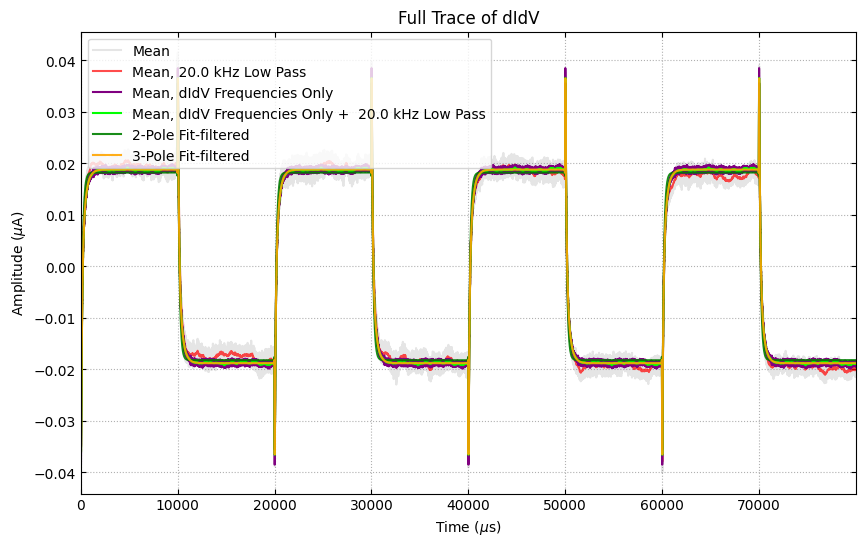

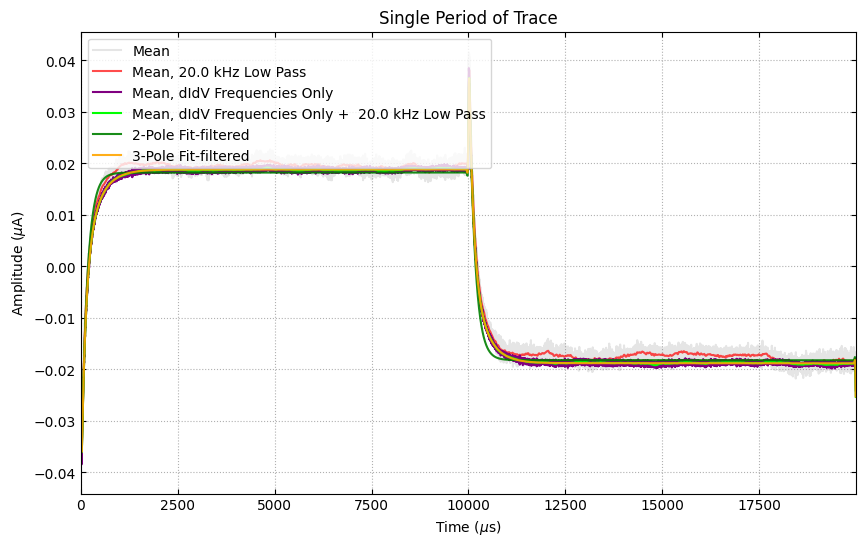

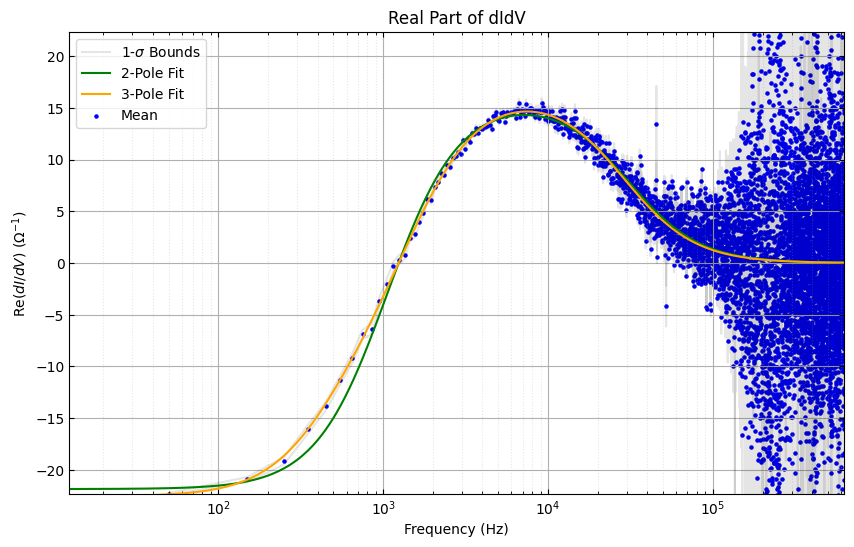

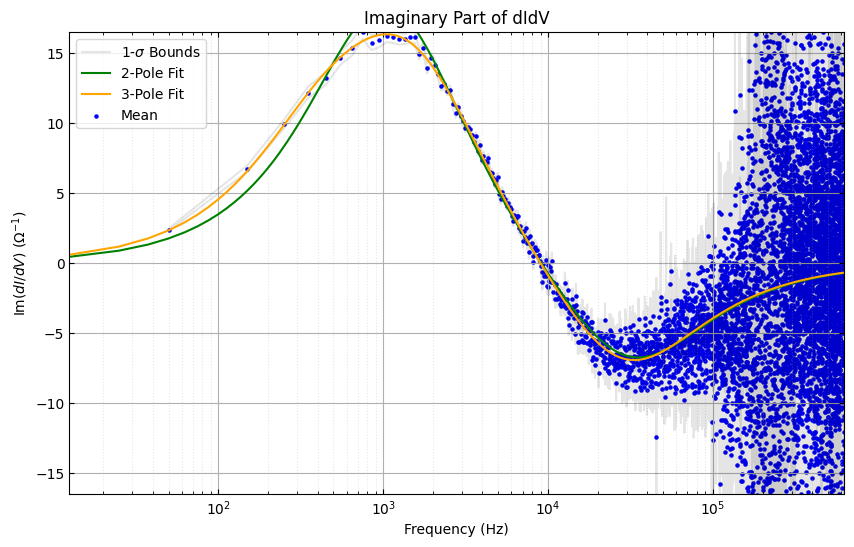

In [43]:
#plotting the fits 
# display fit
#Sapphire
didvobj_sap.plot_full_trace(lp_cutoff=20e3, didv_freq_filt=True, gray_mean=True, savepath=basedir)
didvobj_sap.plot_single_period_of_trace(lp_cutoff=20e3, didv_freq_filt=True, gray_mean=True, savepath=basedir) 
didvobj_sap.plot_re_im_didv(savepath=basedir)

## IrPt Small

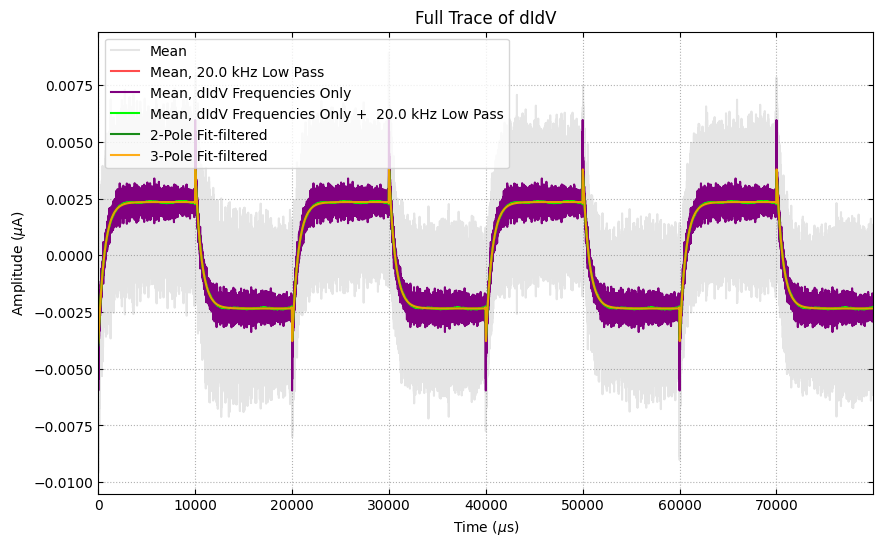

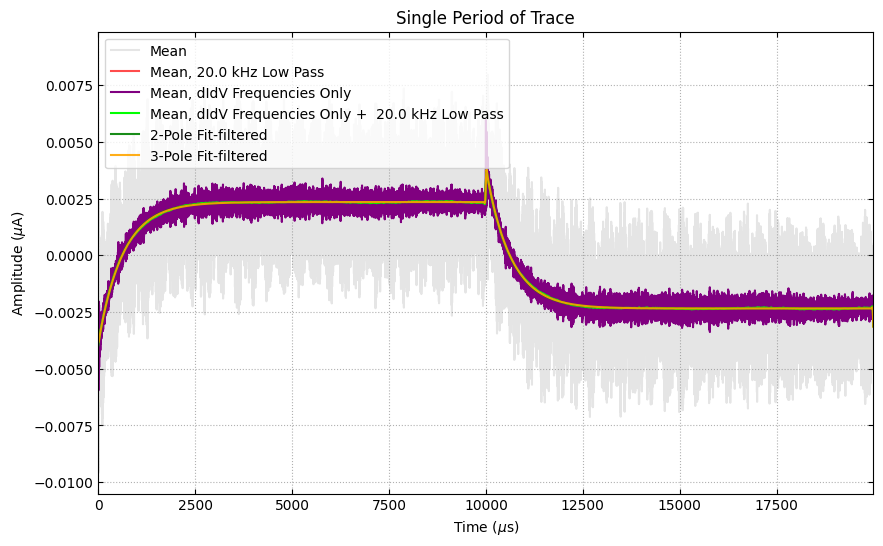

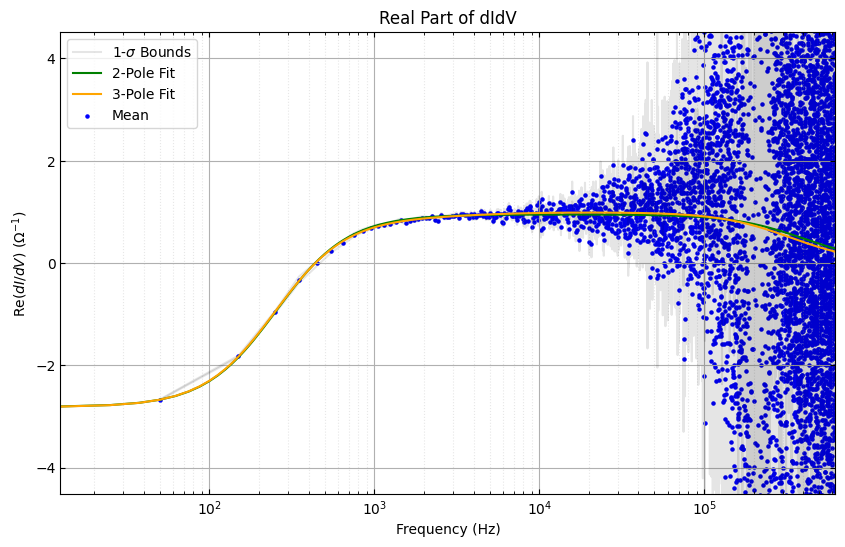

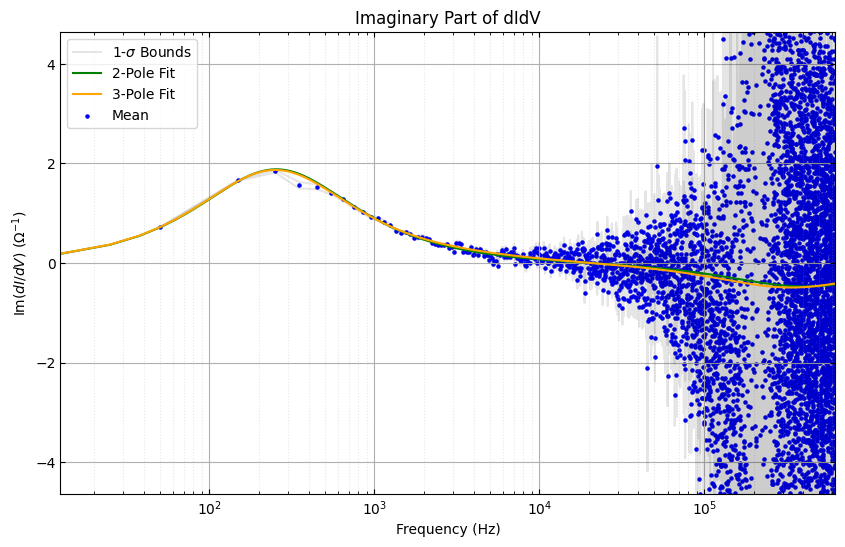

In [44]:
#plotting the fits 
# display fit
#IrPtsmall
didvobj_small.plot_full_trace(lp_cutoff=20e3, didv_freq_filt=True, gray_mean=True, savepath=basedir)
didvobj_small.plot_single_period_of_trace(lp_cutoff=20e3, didv_freq_filt=True, gray_mean=True, savepath=basedir) 
didvobj_small.plot_re_im_didv(savepath=basedir)

## IrPt Big

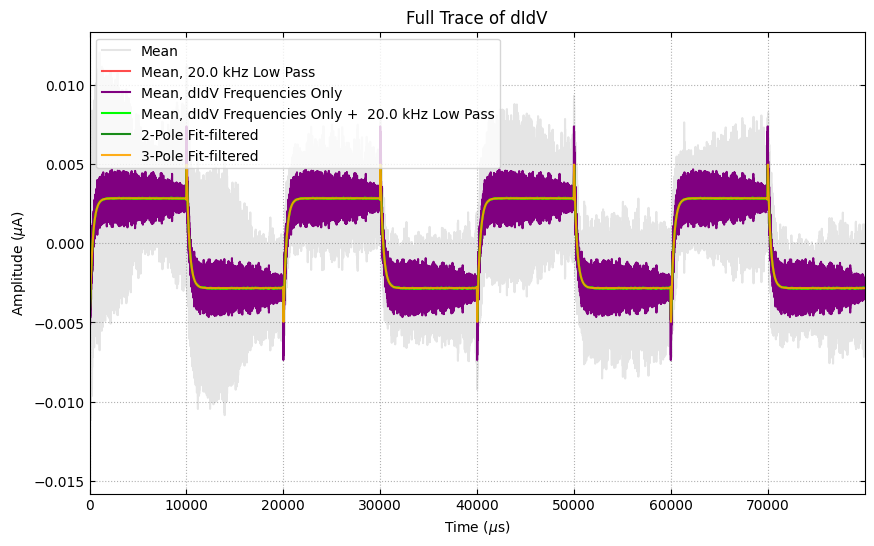

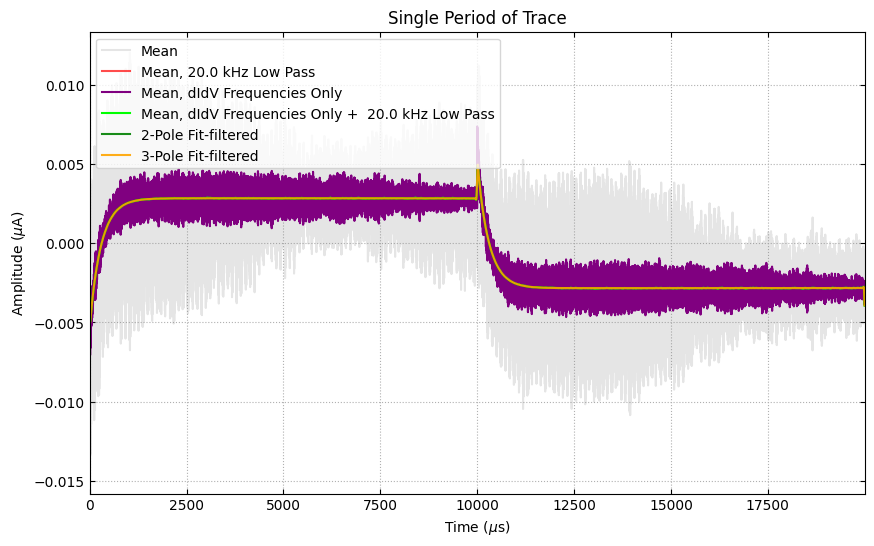

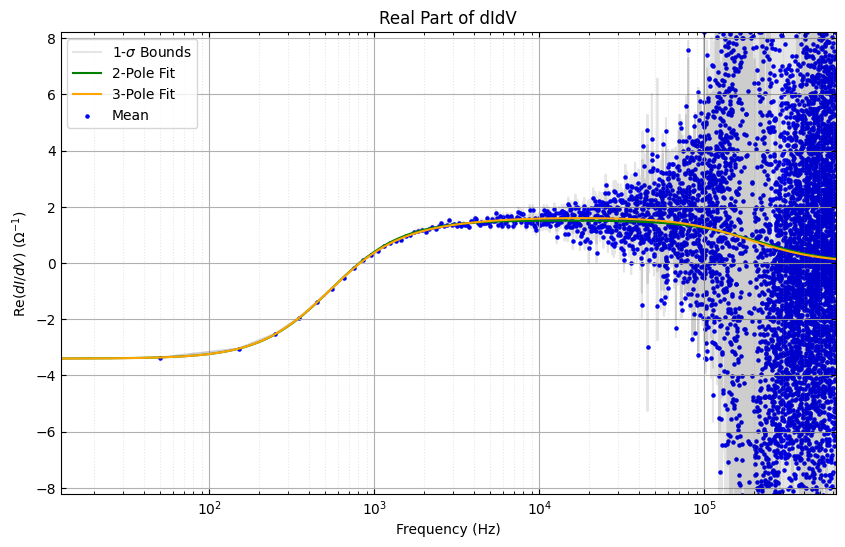

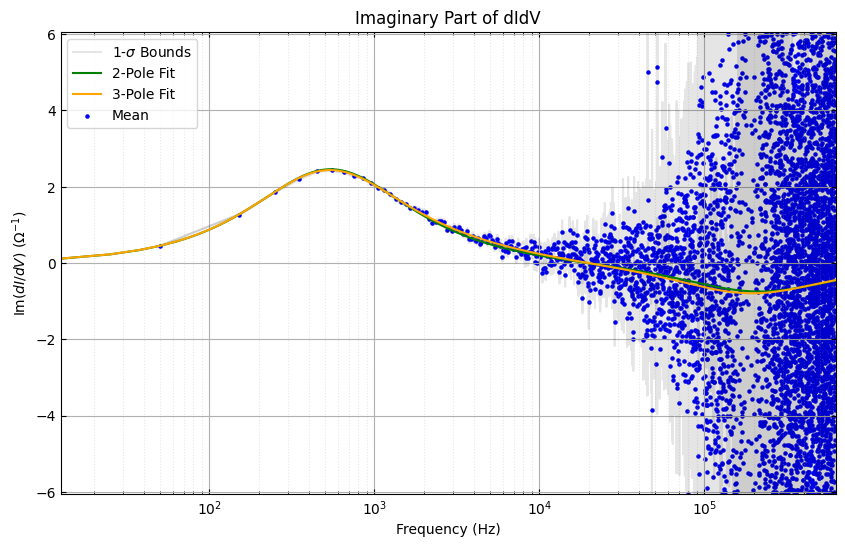

In [45]:
#plotting the fits 
# display fit
#IrPt big
didvobj_big.plot_full_trace(lp_cutoff=20e3, didv_freq_filt=True, gray_mean=True, savepath=basedir)
didvobj_big.plot_single_period_of_trace(lp_cutoff=20e3, didv_freq_filt=True, gray_mean=True, savepath=basedir) 
didvobj_big.plot_re_im_didv(savepath=basedir)

# True current dIdV 

In [46]:
rq_files_path = '/home/maggie_reed/processing/run35/didv/RQfiles/sweeps2/'
save_path = '/sdata2/runs/run35/RQFiles/sweeps2/'
#Load in the offsets dictionary we made in the IV sweep
#"sweeps2" is the sweep made near the end of the run, and as such is a good sweep to select for this set of data
save_dict_name = 'offsets_CPDv21Al2O3_'
with open(rq_files_path + save_dict_name, 'rb') as handle:
    offsets_dict_sap = pickle.load(handle)
save_dict_name = 'offsets_IrPtTESSmallV2_'
with open(rq_files_path + save_dict_name, 'rb') as handle:
    offsets_dict_small = pickle.load(handle)
save_dict_name = 'offsets_IrPtTESBigV2_'
with open(rq_files_path + save_dict_name, 'rb') as handle:
    offsets_dict_big = pickle.load(handle)

In [69]:
channels = ['CPDv21Al2O3','IrPtTESSmallV2','IrPtTESBigV2']
didvobj_all = [didvobj_sap, didvobj_small, didvobj_big]
offset_dict_all = [offsets_dict_sap, offsets_dict_small, offsets_dict_big]
file_list = glob(f'{data_path}/*{didv_bor_series}_*.hdf5')
result_all = []
result_all2 = []

In [70]:
for ichan, chan in enumerate(channels):
    print(f'Starting true fit of {chan}')
    chans = [str(chan)]
    channel_num=0
    didvobj = didvobj_all[ichan]
    offset_dict = offset_dict_all[ichan]
    traces_temp, metadata = h5.read_many_events(filepath = file_list,
                                                    nevents=2,
                                                    output_format=2,
                                                    detector_chans=chans,
                                                    include_metadata=True,
                                                    adctoamp = True)
    
    output_offset = float(metadata[0]['detector_config'][chan]['output_offset'])
    closed_loop_norm = float(metadata[0]['detector_config'][chan]['close_loop_norm'])
    ibias_metadata = float(metadata[0]['detector_config'][chan]['tes_bias'])
    output_gain = float(metadata[0]['detector_config'][chan]['output_gain'])
    
    didvobj.dofit_with_true_current(offset_dict, output_offset, closed_loop_norm, output_gain, ibias_metadata)
    result = didvobj.fitresult(3) #this is the actual object we inspect when we want to know information
    result2 = didvobj.fitresult(2)
    #about the dIdV fit
    result_all.append(result)
    result_all2.append(result2)
    filename = 'true_current_results_2'+ chan
    with open(save_path + filename + ".pickle", 'wb') as handle:
        pickle.dump(result, handle)
    print('Saved true fit result under: ', (save_path+filename+'.pickle'))
print('Done with true fit!')

Starting true fit of CPDv21Al2O3
Saved true fit result under:  /sdata2/runs/run35/RQFiles/sweeps2/true_current_results_2CPDv21Al2O3.pickle
Starting true fit of IrPtTESSmallV2
Saved true fit result under:  /sdata2/runs/run35/RQFiles/sweeps2/true_current_results_2IrPtTESSmallV2.pickle
Starting true fit of IrPtTESBigV2
Saved true fit result under:  /sdata2/runs/run35/RQFiles/sweeps2/true_current_results_2IrPtTESBigV2.pickle
Done with true fit!


# Template generation from true didv fit

In [139]:
from qetpy.utils import make_template_twopole, make_template_threepole
from qetpy.core.didv._templates_didv import _p_delta_frequency, _p_pulse_frequency, get_didv_template, get_phonon_template
from qetpy.core.didv._templates_didv import get_simple_energy_normalization, get_energy_normalization


In [72]:
from detprocess import Template
template_gen = Template(verbose=True)

In [132]:
# time array, 100 ms long, at a sample fequency fs
t_arr = np.arange(0, 2e-2, 1/fs)

template_didv_small = get_didv_template(t_arr, 1e-2, result_all[1])
template_didv_big = get_didv_template(t_arr, 1e-2, result_all[2])
template_didv_sap = get_didv_template(t_arr, 1e-2, result_all[0])
'''
template2_didv_small = get_didv_template(t_arr, 1e-2, result_all2[1])
template2_didv_big = get_didv_template(t_arr, 1e-2, result_all2[2])
template2_didv_sap = get_didv_template(t_arr, 1e-2, result_all2[0])
'''

'\ntemplate2_didv_small = get_didv_template(t_arr, 1e-2, result_all2[1])\ntemplate2_didv_big = get_didv_template(t_arr, 1e-2, result_all2[2])\ntemplate2_didv_sap = get_didv_template(t_arr, 1e-2, result_all2[0])\n'

In [133]:
template_all = [template_didv_sap,template_didv_small,template_didv_big]
#template2_all = [template2_didv_sap,template2_didv_small,template2_didv_big]

In [129]:
template_all = [template_didv_sap[:-1],template_didv_small[:-1],template_didv_big[:-1]]

Template for CPDv21Al2O3...
3pole Rise time: 5.629027796802337
3pole Fall time1: 105.19159241509306
3pole Fall time2: 348.4304471287197
2pole Rise time: 5.217454515989925
2pole Fall time: 150.26972511222763


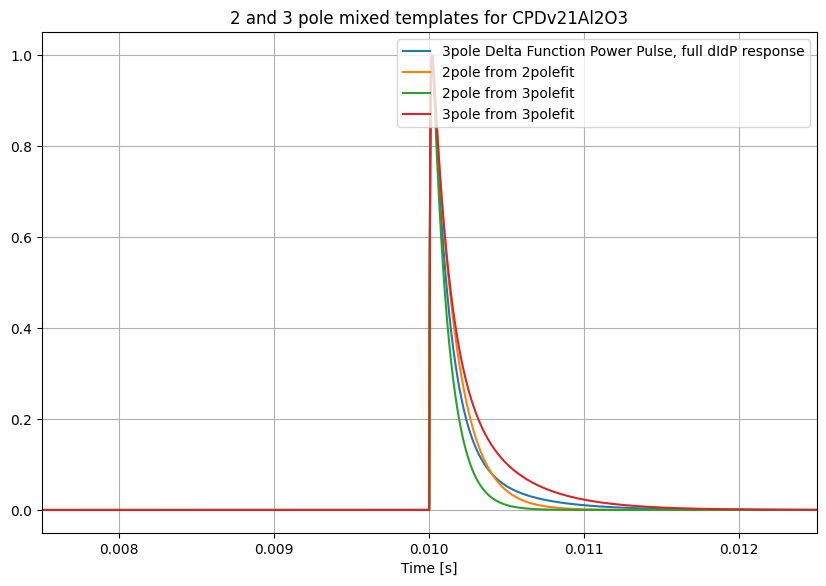

Template for IrPtTESSmallV2...
3pole Rise time: 0.4755555522266525
3pole Fall time1: 38.16396732332438
3pole Fall time2: 636.1216170962143
2pole Rise time: 0.3938974168516403
2pole Fall time: 625.1508804419284


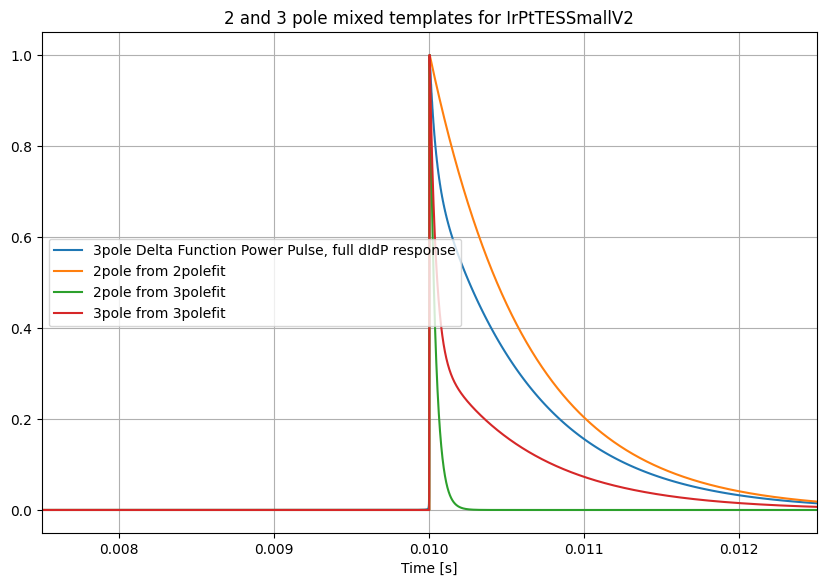

Template for IrPtTESBigV2...
3pole Rise time: 0.8343338590511367
3pole Fall time1: 41.11995937449297
3pole Fall time2: 298.60084535188076
2pole Rise time: 0.7462260000324321
2pole Fall time: 292.74775165684144


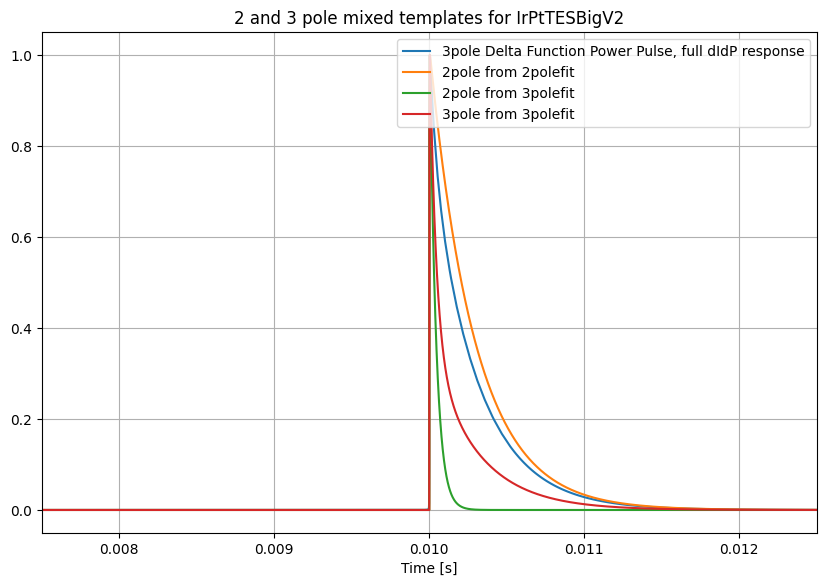

In [80]:
for ichan,chan in enumerate(channels):
    print(f'Template for {chan}...')
    tau_p = np.abs(result_all[ichan]['falltimes'][0])
    tau_m = np.abs(result_all[ichan]['falltimes'][1])
    tau_m2 = np.abs(result_all[ichan]['falltimes'][2])
    # taus from the two pole fit 
    twopole_tau_p = np.abs(result_all2[ichan]['falltimes'][0])
    twopole_tau_m = np.abs(result_all2[ichan]['falltimes'][1])
    print(f'3pole Rise time: {tau_p*1e6}')
    print(f'3pole Fall time1: {tau_m*1e6}')
    print(f'3pole Fall time2: {tau_m2*1e6}')
    print(f'2pole Rise time: {twopole_tau_p*1e6}')
    print(f'2pole Fall time: {twopole_tau_m*1e6}')
    plt.plot(t_arr, template_all[ichan], label = "3pole Delta Function Power Pulse, full dIdP response")
    #plt.plot(t_arr, template2_all[ichan], label = "2pole Delta Function Power Pulse, full dIdP response")

    plt.plot(t_arr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6, tau_r=twopole_tau_p, tau_f=twopole_tau_m), label='2pole from 2polefit')
    plt.plot(t_arr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m), label='2pole from 3polefit')
    plt.plot(t_arr, make_template_threepole(t_arr, A = 1.0, B=0.5, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f1=tau_m, tau_f2=tau_m2), label='3pole from 3polefit')

    plt.xlim(0.0075,0.0125)
    plt.title(f'2 and 3 pole mixed templates for {chan}')
    plt.legend()
    plt.grid('both')
    plt.xlabel('Time [s]')
    plt.show()

## Plotting over actual traces to see

In [82]:
from detanalysis import Analyzer 

In [104]:
#loading in the frame that was processed with the didv template (full dIdP response)
myanalyzer = Analyzer('/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/feature_I2_D20231130_T161010',series=None)

In [105]:
highsingles_SmallEcut = myanalyzer.df.amp_of1x1_constrained_IrPtTESBigV2 <2.5e-8
lowsingles_SmallEcut = myanalyzer.df.amp_of1x1_constrained_IrPtTESBigV2 >1.5e-8
myanalyzer.register_cut(highsingles_SmallEcut,'SmallTES_singles',mode='and',overwrite=True)
myanalyzer.register_cut(lowsingles_SmallEcut,'SmallTES_singles',mode='and',overwrite=True)

In [106]:
traces_small,info_small = myanalyzer.get_traces(channels='IrPtTESSmallV2',raw_path='/sdata2/runs/run35/raw/continuous_I2_D20231122_T215934',cut = 'SmallTES_singles',nb_random_samples=100,trace_length_msec = 100)
traces_big,info_big = myanalyzer.get_traces(channels='IrPtTESBigV2',raw_path='/sdata2/runs/run35/raw/continuous_I2_D20231122_T215934',nb_random_samples=100,trace_length_msec = 100)

INFO: Number of events found = 100
INFO: Number of events found = 100


In [107]:
lowpassedtraces_small = []
lowpassedtraces_big = []

lowpassedtraces_small = qp.utils.lowpassfilter(traces_small,cut_off_freq=30000,fs=fs)
lowpassedtraces_big = qp.utils.lowpassfilter(traces_big,cut_off_freq=30000,fs=fs)

In [90]:
t_arr=t_arr[:-1]

In [97]:
timearr = np.linspace(0,100,125000)

In [98]:
timearr.shape

(125000,)

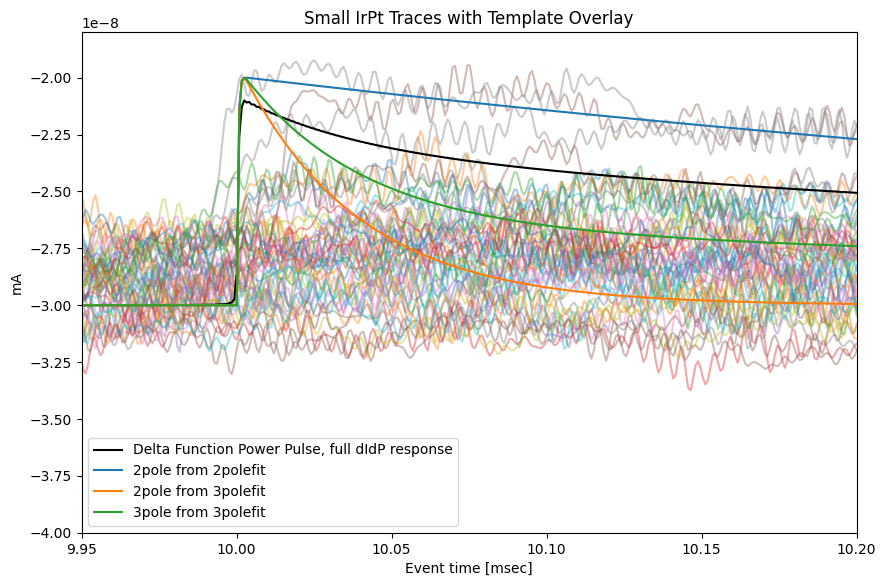

In [127]:
for xx in lowpassedtraces_small[0:50,0]:
    plt.plot(timearr, xx, alpha=0.4)
    
tau_p = np.abs(result_all[1]['falltimes'][0])
tau_m = np.abs(result_all[1]['falltimes'][1])
tau_m2 = np.abs(result_all[1]['falltimes'][2])
# taus from the two pole fit 
twopole_tau_p = np.abs(result_all2[1]['falltimes'][0])
twopole_tau_m = np.abs(result_all2[1]['falltimes'][1])    
plt.plot(timearr, template_all[1]*9e-9-0.3e-7, label = "Delta Function Power Pulse, full dIdP response",color='black')
plt.plot(timearr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6, 
                                      tau_r=twopole_tau_p, 
                                      tau_f=twopole_tau_m)*1e-8 -0.3e-7, label='2pole from 2polefit')
plt.plot(timearr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6,
                                      tau_r=tau_p, 
                                      tau_f=tau_m)*1e-8 -0.3e-7, label='2pole from 3polefit')
plt.plot(timearr, make_template_threepole(t_arr, A = 1.0, B=0.5, t0 =1e-2, fs = 1.25e6,
                                        tau_r=tau_p, 
                                        tau_f1=tau_m, 
                                        tau_f2=tau_m2)*1e-8 -0.3e-7, label='3pole from 3polefit')
plt.xlabel('Event time [msec]')
plt.ylabel('mA')
plt.title('Small IrPt Traces with Template Overlay')
plt.legend()
plt.xlim(9.95, 10.2)
plt.ylim(-0.4e-7,-0.18e-7)
plt.show()

## Note! 

The template generated for the small device looks **pretty bad**. The big device isn't the greatest either.

# Of amp to ev conversion factors 

In [57]:
for ichan,chan in enumerate(channels):
    ofamp_to_ev = get_energy_normalization(t_arr, template_all[ichan], result_all[ichan], lgc_ev=True)
    print(f'{chan} Ofamp to eV: ',ofamp_to_ev)

CPDv21Al2O3 Ofamp to eV:  131573193.23997273
IrPtTESSmallV2 Ofamp to eV:  176200062.40282878
IrPtTESBigV2 Ofamp to eV:  376246664.56581753


# Saving the template into pre made filter file

In [134]:
file_name = '/home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5'
for ichan,chan in enumerate(channels):
    template_gen.set_template(chan, template_all[ichan], sample_rate=1.25e6,
                          pretrigger_length_msec=10)
    template_gen.save_hdf5(file_name, overwrite=True)

INFO: Saving noise data to file /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
INFO: channel data with same tag may be overwritten
Storing /CPDv21Al2O3/psd_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /CPDv21Al2O3/psd_fold_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /CPDv21Al2O3/template_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /IrPtTESSmallV2/psd_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /IrPtTESSmallV2/psd_fold_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /IrPtTESSmallV2/template_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /IrPtTESBigV2/psd_default in /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5
Storing /IrPtTESBigV2/psd_fold_default in 

In [135]:
template_gen.load_hdf5(file_name)
template_gen.describe()

INFO: Loading filter data from file /home/maggie_reed/processing/run35/continuous/run35_filter_1122_20ms.hdf5

Channel CPDv21Al2O3:
 * Tag "default":
    psd: pandas.Series (25000,)
    psd_fold: pandas.Series (12501,)
    template: pandas.Series (25000,)

Channel IrPtTESSmallV2:
 * Tag "default":
    psd: pandas.Series (25000,)
    psd_fold: pandas.Series (12501,)
    template: pandas.Series (25000,)

Channel IrPtTESBigV2:
 * Tag "default":
    psd: pandas.Series (25000,)
    psd_fold: pandas.Series (12501,)
    template: pandas.Series (25000,)


# Correlated and Uncorrelated Noise Analysis

In [140]:
trigger_path = '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624'
chans = channels #channel names

filelist = sorted(glob(trigger_path + "/r*"))
print(filelist)
    
file = filelist[0]
traces, info = h5.read_many_events(filepath = file, detector_chans = None, nevents = 0,
                                   output_format = 2, include_metadata = True, adctoamp = True, memory_limit = 10)
    
for fileind in range(1,len(filelist)):
    file = filelist[fileind]
    temp_traces, temp_info = h5.read_many_events(filepath = file, detector_chans = None, nevents = 0,
                                                 output_format = 2, include_metadata = True, adctoamp = True, memory_limit = 10)
        
    traces = np.append(traces, temp_traces, axis = 0)
    info = np.append(info, temp_info, axis = 0)
    print("File " + str(file) + " loaded")

['/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131625_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131626_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131627_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131628_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131629_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131630_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T131624/rand_I2_D20231201_T131631_F0001.hdf5', '/sdata2/runs/run35/processed/continuous_I2_D20231122_T215934/trigger_I2_D20231201_T13162

KeyError: 'adc1'

In [ ]:
#populate traces for devices channels = ['CPDv21Al2O3','IrPtTESSmallV2','IrPtTESBigV2']

traces_0 = [] #CPDv21Al2O3
traces_1 = [] #IrPtTESSmallV2
traces_2 = [] #IrPtTESBigV2
i = 0
while i < len(traces):
    traces_0.append(traces[i][0])
    traces_1.append(traces[i][1])
    traces_2.append(traces[i][2])
    if i % 1000 == 0:
        print("Done with " + str(i))
    i += 1

traces_0 = np.asarray(traces_0)
traces_1 = np.asarray(traces_1)
traces_2 = np.asarray(traces_2)

In [ ]:
traces_all = traces[:,0:3]
chans_all = ['CPDv21Al2O3','IrPtTESSmallV2','IrPtTESBigV2']

In [ ]:
#Use Noise class to calculate the decorrelated components of noise
NC = qp.Noise(traces_all, fs, chans_all)
NC.calculate_csd() # cross spectral densisty (power between channels)

NC.calculate_uncorr_noise()

In [ ]:
f_fold = NC.freqs

fig, ax = plt.subplots(figsize=2*np.array([1.5, 1]) * (3 + 3/8))

colors = ['r', 'b', 'forestgreen']
ecolors = ['grey', 'tan', 'black']

c = cm.magma(np.linspace(0,1,4))
for ii in range(0,3):
    fig, ax = plt.subplots()
    
    ax.step(NC.freqs[1:], np.sqrt(NC.real_csd[ii][ii][1:]),
                alpha=1, color='royalblue', label=chans_all[ii], where='mid')
                    
    ax.step(NC.freqs[1:],np.sqrt(NC.uncorrnoise[ii][1:]),
                            label='Uncorrelated Noise',alpha = 1, color='limegreen', where='mid')

    ax.step(NC.freqs[1:], np.sqrt(NC.corrnoise[ii][1:]), label='Correlated Noise',
                alpha=0.6, color='orangered', where='mid')
    plt.xscale('log')
    plt.yscale('log')
    ax.set_ylim(1e-12, 5e-10)
    ax.set_ylabel(r'Current CSD [A/$\sqrt{\mathrm{Hz}}$]')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.grid(b=True, linestyle='dotted', color='k', which='major')
    ax.grid(b=True, linestyle='--', alpha=0.1, color='k', which='minor')
    ax.legend()
    #plt.savefig(chans[ii]+'_corr.png', dpi=300)